# Model prediction example
This notebook briefly demonstrates:
- loading a trained model and example audio clip
- computing model outputs
- post-processing model predictions into discrete detections

## Import required libraries

In [1]:
from matplotlib import pyplot as plt
import librosa
import numpy as np
import os
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import torch
import utils
import model.net as net

## Load trained model

In [2]:
model_dir = 'experiments/base_model'
json_path = os.path.join(model_dir, 'params.json')
params = utils.Params(json_path)
model = net.Net(params).cuda() if torch.cuda.is_available() else net.Net(params)

restore_path = os.path.join(model_dir, 'pretrained.pth.tar')
_ = utils.load_checkpoint(restore_path, model, optimizer=None)

## Load example audio clip and compute model output

In [3]:
x, sr = librosa.load('covey_clip.wav', sr=24000, mono=True, duration=4)

batch = {"input": torch.tensor(x).view(1,-1).cuda() if torch.cuda.is_available() else torch.tensor(x)}
with torch.no_grad():
    output_dict = model(batch)

mel_spec = output_dict['mel_spec'][0,0,:,:].cpu().numpy()
predictions = output_dict['logits'][0,0,:,:].sigmoid().cpu().numpy()
time = librosa.frames_to_time(np.arange(mel_spec.shape[-1]), sr=sr, hop_length=params.hop_length)
extent = [time[0], time[-1], 0, mel_spec.shape[0]]

## Plot input mel-spectrogram

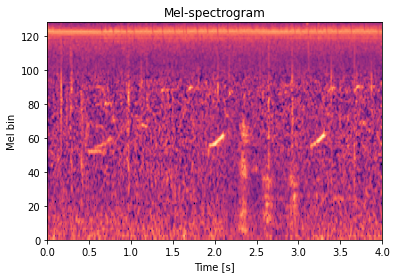

In [4]:
plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='magma', extent=extent)
plt.xlabel('Time [s]')
plt.ylabel('Mel bin')
plt.title('Mel-spectrogram')
plt.show()

## Plot output predictions

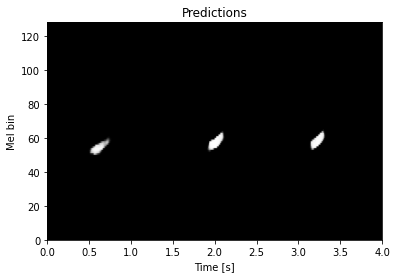

In [5]:
plt.imshow(predictions, origin='lower', aspect='auto', cmap='gray', extent=extent)
plt.xlabel('Time [s]')
plt.ylabel('Mel bin')
plt.title('Predictions')
plt.show()

## Post-process model predictions

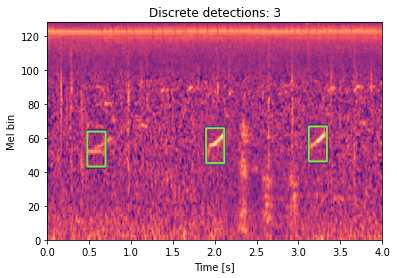

In [6]:
peak_idx = peak_local_max(predictions, min_distance=21, threshold_abs=0.5)
peak_mask = np.zeros_like(predictions, dtype=int)
peak_mask[tuple(peak_idx.T)] = 1

peak_mask = ndi.maximum_filter(peak_mask, size=21, mode='constant')
labeled_array, num_detections = ndi.label(peak_mask)

plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='magma', extent=extent)
plt.contour(peak_mask, extent=extent)
plt.xlabel('Time [s]')
plt.ylabel('Mel bin')
plt.title('Discrete detections: {}'.format(num_detections))
plt.show()